# CNN-DNN

Information...

## Load packages

In [139]:
import os, sys, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sys.path.append('../scripts')
from CNN import CNNBlock

In [234]:
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError as rmse
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Input, Embedding, Concatenate, Dense, Flatten, Dropout

## Create model

In [116]:
combos = os.listdir('../data/complete_weather')
complete_combos = []
count=0
for c in combos:
    pth = os.path.join('..', 'data', 'complete_weather', c)
    df = pd.read_csv(pth)
    n_missing = df.shape[0] - df.dropna().shape[0]
    if n_missing == 0:
        complete_combos.append(c)
    elif df.shape[0] == n_missing:
        count += 1
    else:
        print(c + '; days missing weather: ' + str(n_missing))

columbia valley-1999.csv; days missing weather: 12
willamette valley-2018.csv; days missing weather: 3
carneros-2000.csv; days missing weather: 10
north coast-2000.csv; days missing weather: 17
columbia valley-1997.csv; days missing weather: 174
RRV-2000.csv; days missing weather: 17
sonoma-2000.csv; days missing weather: 17
napa-2000.csv; days missing weather: 10


In [114]:
count

133

In [115]:
len(combos)

290

In [63]:
len(complete_combos)

149

In [551]:
lr = 1e-2
decay = ExponentialDecay(lr, decay_steps=50, decay_rate=0.96)
adam_decay = Adam(decay)

earlystopping = EarlyStopping(min_delta=0.0, patience=20)

In [552]:
grape_input = Input(shape=(1,))
grape = Dense(1)(grape_input)
weather_input = Input(shape=(245,7))

cnn = CNNBlock(wfilt=16, mfilt=16)
x = cnn(weather_input)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)

x = Concatenate()([x, grape])
x = Dense(8, activation='relu')(x)
x = Dense(1, activation='relu')(x)

In [553]:
model = Model(inputs=[grape_input, weather_input], outputs=x)
model.compile(loss='mean_squared_error', optimizer=adam_decay,
             metrics=[rmse()])

## Data

In [554]:
df = pd.read_csv('../data/wine_data_final.csv')
df = df[df.file.isin(complete_combos)]
df.head()

,skin,file,quality
0,1,RRV-2008.csv,91.0
1,1,RRV-2020.csv,92.5
5,1,RRV-2009.csv,88.5
6,0,sonoma-2009.csv,88.0
7,1,sonoma-2009.csv,91.0


In [555]:
df.shape

(188, 3)

In [556]:
np.random.seed(34)
ids = set(df.index.tolist())
test = set(df.sample(n=20).index.tolist())
train = ids - test
val = set(df.loc[ids, :].sample(n=15).index.tolist())
train = train - val

In [557]:
df_train = df.loc[train, :]
df_val = df.loc[val, :]
df_test = df.loc[test, :]

s_train = df_train.skin.values
gt_train = df_train.quality.values

s_val = df_val.skin.values
gt_val = df_val.quality.values

s_test = df_test.skin.values
gt_test = df_test.quality.values

In [558]:
def fetch_weather(x):
    pth = os.path.join('..', 'data', 'complete_weather', x)
    weather = pd.read_csv(pth)
    return weather.values

def compile_weather(data, xs):
    for i, x in enumerate(xs):
        f = data.loc[x, 'file']
        if i == 0:
            n1 = fetch_weather(f)
        else:
            n2 = fetch_weather(f)
            n1 = np.concatenate((n1, n2), axis=0)
    return n1.reshape(i+1,245,7)

In [559]:
w_train = compile_weather(df, train)
w_val = compile_weather(df, val)
w_test = compile_weather(df, test)

## Train Model

In [567]:
model.fit(x=[s_train, w_train], y=gt_train,
          validation_data=([s_val, w_val], gt_val),
          epochs=100, callbacks=[earlystopping])

Epoch 1/100
5/5 [==============================] - 0s 21ms/step - loss: 18.9429 - root_mean_squared_error: 4.3523 - val_loss: 40.0756 - val_root_mean_squared_error: 6.3305
Epoch 2/100
5/5 [==============================] - 0s 20ms/step - loss: 19.7356 - root_mean_squared_error: 4.4425 - val_loss: 29.8485 - val_root_mean_squared_error: 5.4634
Epoch 3/100
5/5 [==============================] - 0s 20ms/step - loss: 22.7693 - root_mean_squared_error: 4.7717 - val_loss: 36.6965 - val_root_mean_squared_error: 6.0578
Epoch 4/100
5/5 [==============================] - 0s 19ms/step - loss: 22.5747 - root_mean_squared_error: 4.7513 - val_loss: 44.8267 - val_root_mean_squared_error: 6.6953
Epoch 5/100
5/5 [==============================] - 0s 19ms/step - loss: 20.2236 - root_mean_squared_error: 4.4971 - val_loss: 47.0940 - val_root_mean_squared_error: 6.8625
Epoch 6/100
5/5 [==============================] - 0s 19ms/step - loss: 24.6363 - root_mean_squared_error: 4.9635 - val_loss: 51.8117 - val_

In [568]:
preds = model.predict([s_test, w_test]).T[0]

In [569]:
def pred_lim(x):
    if x > 100: 
        return 100
    else:
        return x
    
res = pd.DataFrame({'grape':s_test, 'pred':preds, 'true': gt_test})
res.pred = res.pred.apply(pred_lim)
res.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
grape,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0,0.000000,1.000000,1.0,1.0,1.000000,0.000000,0.000000,0.000000,1.000000
pred,94.481041,91.672386,91.762512,91.902008,94.773338,96.357887,96.449913,97.563377,89.430824,100.0,100.0,87.860451,93.354683,100.0,100.0,94.750534,88.244255,91.671265,89.949608,75.877579
true,92.000000,90.000000,89.000000,93.000000,94.000000,94.500000,90.000000,94.000000,89.000000,95.0,92.0,86.500000,93.000000,93.0,94.0,91.000000,85.000000,92.500000,92.500000,86.000000


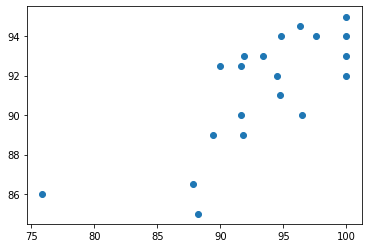

In [570]:
plt.scatter(res.pred, res.true)
plt.show()

In [571]:
from scipy.stats import pearsonr

In [572]:
corr, _ = pearsonr(res.pred, res.true)

In [576]:
# 16, 16 in CNN & 16 -> 4, 1 in DNN
corr

0.7471473627449555

In [575]:
np.sqrt(np.sum((res.pred - res.true)**2)/res.shape[0])

4.3962880958686705